## 0. import libs

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
import pickle
%matplotlib inline

## 1. Histogram of Oriented Gradients (HOG)

### 1.0 extracte_hog and get_hog_features functions

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(img)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)  
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [3]:
cars = glob.glob('./trainingData/vehicles/**/*.png')
notcars = glob.glob('./trainingData/non-vehicles/**/*.png')

if((len(cars)*len(notcars))!=0):
    print("There are %d car images and %d none-car images" %(len(cars), len(notcars)))
else:
    print("Failed to read the training data")

There are 8792 car images and 8968 none-car images


In [4]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


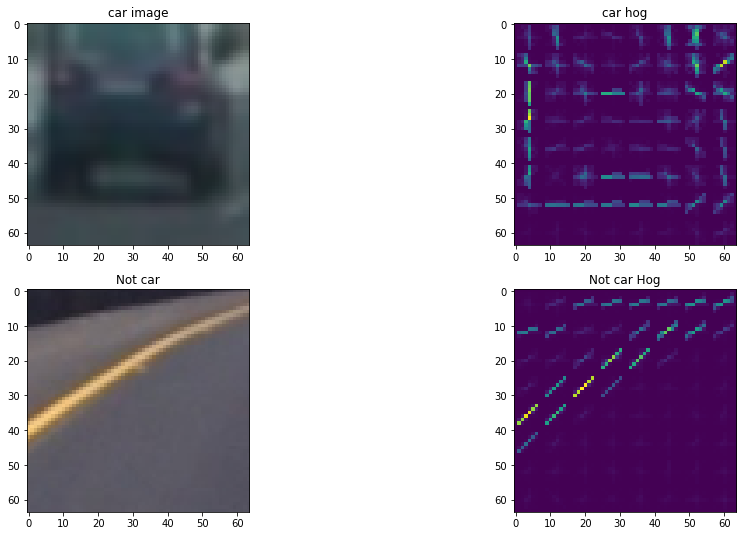

In [5]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


# Visualize
car_image = mpimg.imread(cars[15])
car_channel = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)[:,:,0]
_, car_image_hog = get_hog_features(car_channel,orient, pix_per_cell, cell_per_block,vis=True, feature_vec=True)
notcar_image = mpimg.imread(notcars[10])
notcar_channel = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YUV)[:,:,0]
_, notcar_image_hog = get_hog_features(notcar_channel,orient, pix_per_cell, cell_per_block,vis=True, feature_vec=True)


plt.figure(figsize=(16, 9))
plt.subplot(2, 2, 1)
plt.imshow(car_image)
plt.title("car image")
plt.subplot(2, 2, 2)
plt.imshow(car_image_hog)
plt.title("car hog")

plt.subplot(2, 2, 3)
plt.imshow(notcar_image)
plt.title("Not car")
plt.subplot(2, 2, 4)
plt.imshow(notcar_image_hog)
plt.title("Not car Hog")

In [6]:
# extract features
# parameters are defined in cell 5
tic = time.time()
print("Extrating features, it may need some time")
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))   # 1 is car and 0 is none-car


# Normalization
X_scaler = StandardScaler().fit(X) 
scaled_X = X_scaler.transform(X) 

rand_state = np.random.randint(0, 100)
# seperate the training data into training set and test set. Since the data set is small, I didn't use a validation set
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2,random_state=rand_state)

toc = time.time()

print("Done preparing, time spent: %.2fs" %(toc-tic))
print("Totally %d training data and %d testing data" %(len(X_train), len(X_test)))



Extrating features, it may need some time


D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Done preparing, time spent: 78.26s
Totally 14208 training data and 3552 testing data


### 1.1 Train a classifier

In [7]:
# Train a SVC classifier

print('Feature vector length:', len(X_train[0]))
print("Training SVC...")
svc = LinearSVC()
tic = time.time()
svc.fit(X_train, y_train)
toc = time.time()
print("SVC model trained, time spent %.2fs" % (toc-tic))
print('Test Accuracy of SVC is %.3f' %(svc.score(X_test, y_test)))

Feature vector length: 10224
Training SVC...
SVC model trained, time spent 7.24s
Test Accuracy of SVC is 0.989


In [8]:
# Save the model
joblib.dump(svc, "SVC_model")

fw = open('scaler_data','wb')  
pickle.dump(X_scaler,fw)
fw.close()  

In [9]:
# read the model
svc = joblib.load("SVC_model")
fr = open('scaler_data','rb')  
X_scaler = pickle.load(fr)
fr.close()

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

## 2.Sliding window search

In [10]:
#help functions from lessons tutorials
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """return both image and box list"""
    bboxes = []
    draw_img = np.copy(img)
    img = draw_img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:] 
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)-1 

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
   
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(test_stacked)    
            #test_features = scaler.transform(np.array(features).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))

    return draw_img,bboxes


D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Wall time: 932 ms


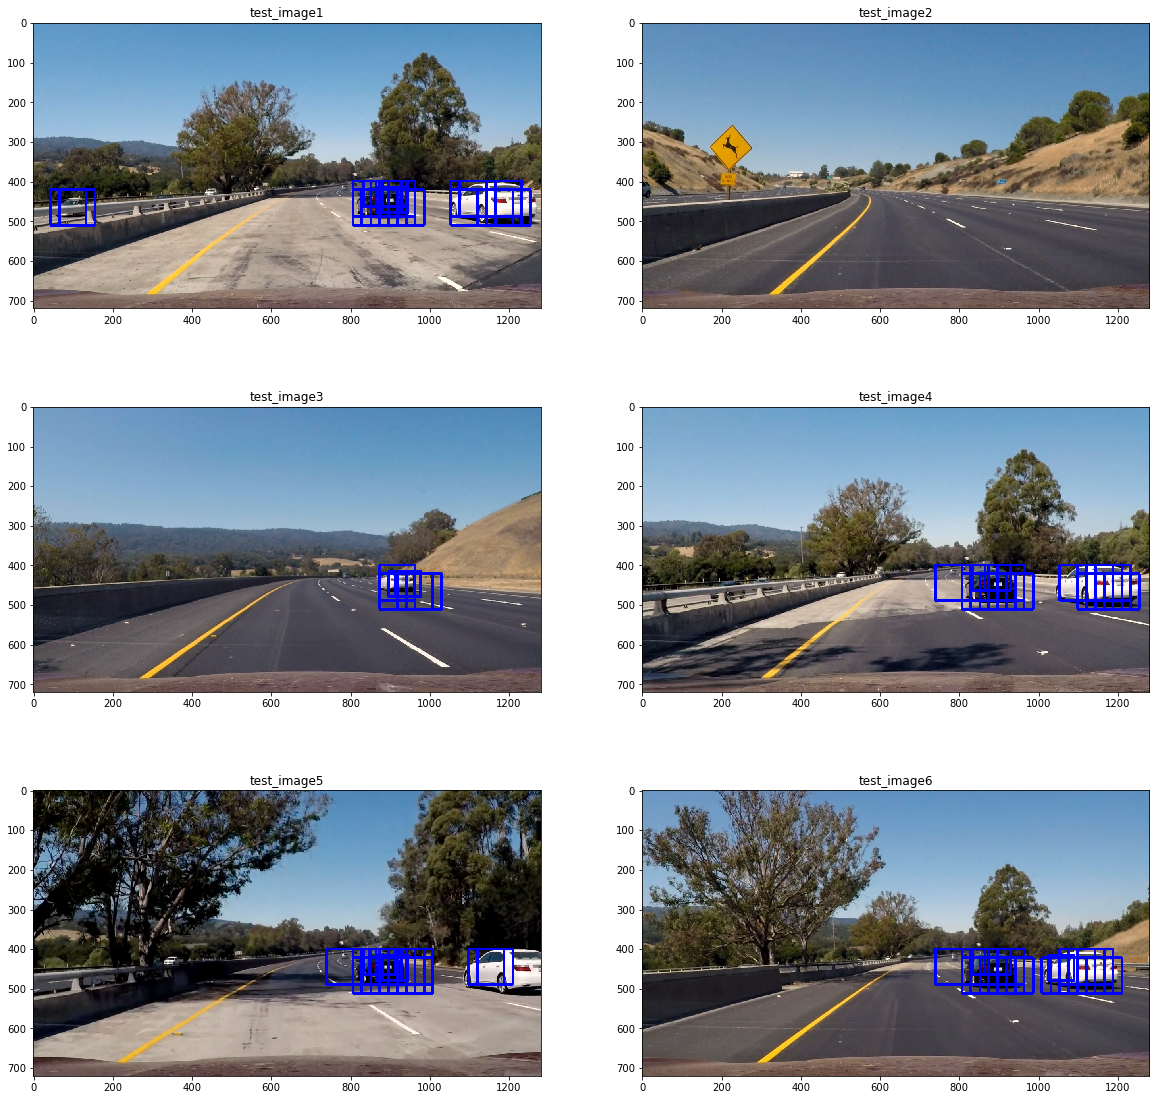

In [11]:
#  multi-scale slide windows search function
# multi-scale sliding
# reduce the calling of find_cars() as much as we can to accelerate the algorithm
def apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    boxes = [0,1,2,3,4,5,6,7,8,9]
#     image,boxes[0] = find_cars(image, 400, 465, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[1] = find_cars(image, 400, 500, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[2] = find_cars(image, 430, 600, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[3] = find_cars(image, 420, 580, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[4] = find_cars(image, 400, 500, 2.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[5] = find_cars(image, 400, 556, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[6] = find_cars(image, 450, 600, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    
    image,boxes[0] = find_cars(image, 400, 500, 1.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    image,boxes[1] = find_cars(image, 400, 500, 1.3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    image,boxes[2] = find_cars(image, 400, 500, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    image,boxes[3] = find_cars(image, 420, 538, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    image,boxes[4] = find_cars(image, 430, 538, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    image,boxes[5] = find_cars(image, 430, 538, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    image,boxes[6] = find_cars(image, 430, 544, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    image,boxes[7] = find_cars(image, 400, 540, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    image,boxes[8] = find_cars(image, 400, 540, 2.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    image,boxes[9] = find_cars(image, 400, 580, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    
#     image,boxes[0] = find_cars(image, 400, 650, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[1] = find_cars(image, 400, 500, 1.4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[2] = find_cars(image, 400, 650, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[3] = find_cars(image, 400, 520, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[4] = find_cars(image, 400, 520, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[5] = find_cars(image, 400, 520, 1.2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

#     image,boxes[6] = find_cars(image, 430, 560, 1.6, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[7] = find_cars(image, 430, 560, 1.8, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[8] = find_cars(image, 430, 560, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     image,boxes[9] = find_cars(image, 500, 660, 3.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    bboxes = []
    for i in range(10):
        if boxes[i] != i:
            bboxes.extend(boxes[i])
    
    return image,bboxes




%time apply_sliding_window(mpimg.imread('./test_images/test1.jpg'), svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.figure(figsize=(20,20))
test_images_names = glob.glob('./test_images/*.jpg')
i=1
for img_name in test_images_names:
    a,b = apply_sliding_window(mpimg.imread(img_name), svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    plt.subplot(3,2,i)
    plt.imshow(a)
    plt.title("test_image"+ str(i))
    i = i+1

## tried a buntch of different sliding parameters, and find the best one


result looks good above, now try combine the boxes into one box if they are overlapping

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


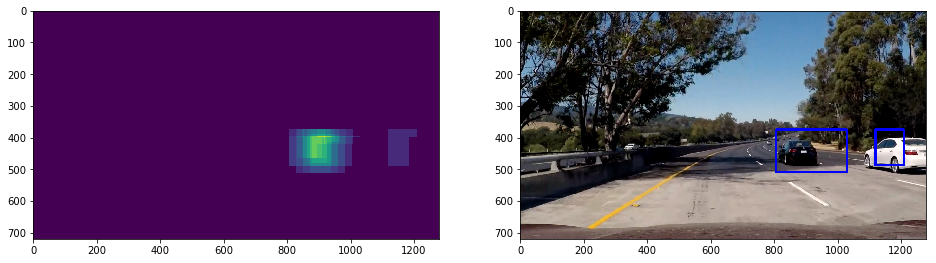

In [12]:
# heat map to draw nicer boxes
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        if box[0][1]>25 and box[1][1]<1265:
            heatmap[box[0][1]-25:box[0][1], box[0][0]:box[1][0]+25] += 1
            

        
    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold=1):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    all_rec = []
    center_point = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        x1,y1,x2,y2 = np.min(nonzerox),np.max(nonzeroy),np.max(nonzerox),np.min(nonzeroy)
        if abs(x1-x2)<40 or abs(y1-y2)<40:
            continue
        if (y1-y2)/(x1-x2)>1.1:
            if x1>20 and x2<1060:
                bbox = ((x1-20, y1), (x2+20, y2))
            elif x1>20 and x2>1060:
                bbox = ((x1-20, y1), (1079, y2))
            elif x1<20 and x2<1060:
                bbox = ((1, y1), (x2+20, y2))
        else:
            bbox = ((x1, y1), (x2, y2))
        # Draw the box on the image
        
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



# visualize the heat map
image = mpimg.imread('./test_images/test5.jpg')
_, boxes = apply_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
heat = add_heat((np.zeros_like(image)[:,:,0]).astype(np.float),boxes)
heat = apply_threshold(heat,1)
labels = label(heat)
labeled_image = draw_labeled_bboxes(image,labels)
plt.figure(figsize=(16,10))
plt.subplot(221)
plt.imshow(heat)
plt.subplot(222)
plt.imshow(labeled_image)


D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


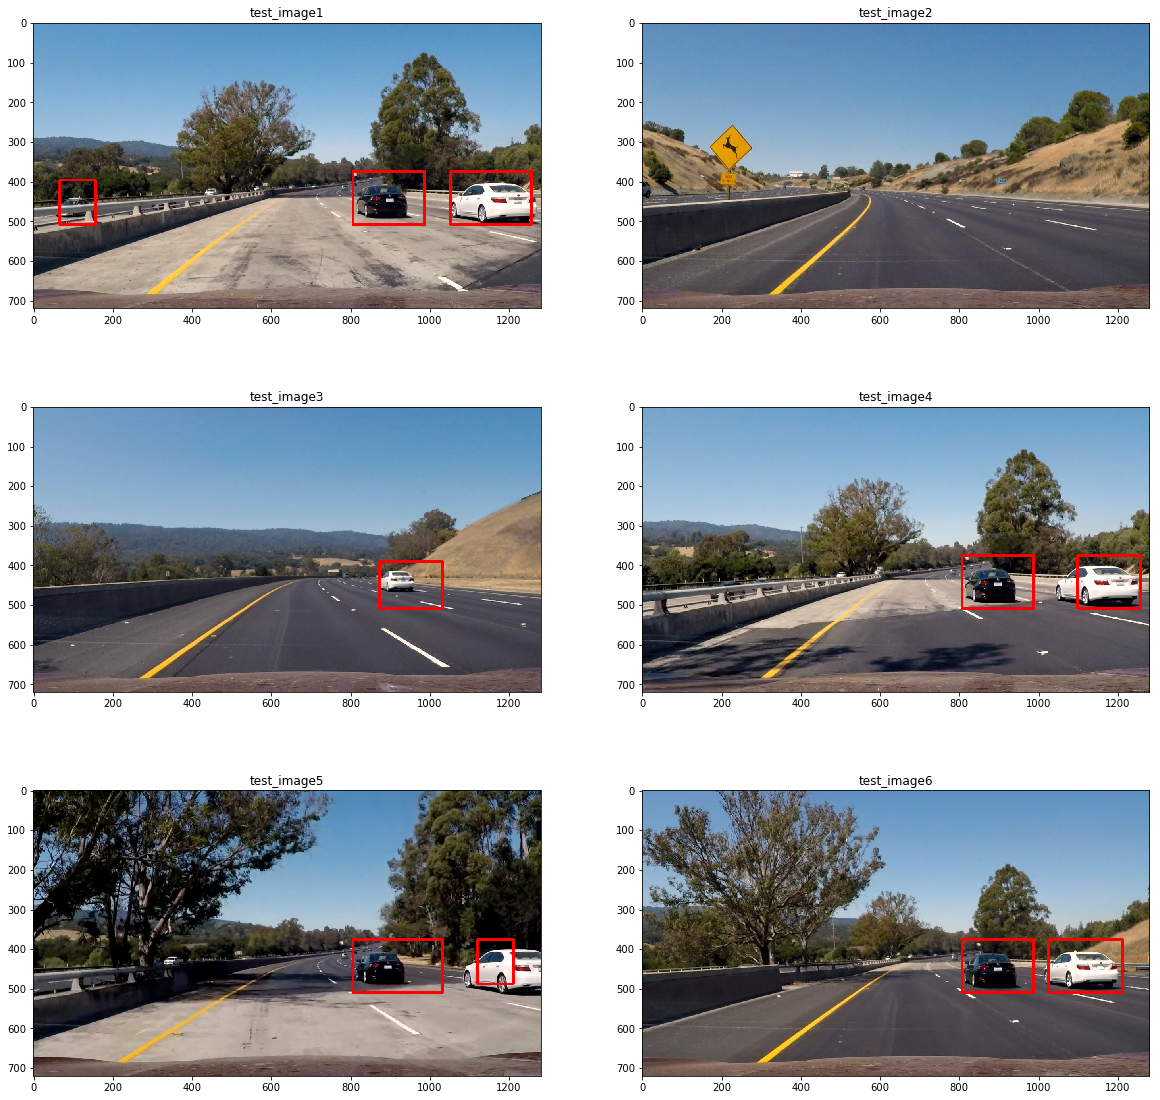

In [13]:
# combine all the methods above into one function
def process_image(img):
    """img is a BGR image since the video process will read file as BGR
    Therefore, it will also return a BGR image"""
    _, boxes = apply_sliding_window(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = add_heat((np.zeros_like(image)[:,:,0]).astype(np.float),boxes)
    heat = apply_threshold(heat,1)
    labels = label(heat)
    labeled_image = draw_labeled_bboxes(np.copy(img),labels)
    return labeled_image


plt.figure(figsize=(20,20))
test_images_names = glob.glob('./test_images/*.jpg')
i=1
for img_name in test_images_names:
    image = process_image(cv2.imread(img_name))
    plt.subplot(3,2,i)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("test_image"+ str(i))
    i = i+1

In [16]:
import sys
def analyze_video(video_src,video_save,func):
    """
    Parameters:
        video_src: a string that represent the address of the video
        video_save: a string that where you want to save the processed video
    """
    cap  = cv2.VideoCapture(video_src)
    success = True
    fourcc = cv2.VideoWriter_fourcc('D', 'I','V','X')
    videoWriter = cv2.VideoWriter(video_save,fourcc,25,(1280,720))
    frame_n = 0
    all_frames = []

    tic = time.time()

    print("Reading video...")
    while(success):
            success, frame = cap.read()
            all_frames.append(frame)
            frame_n+=1
    print("Total frames in this video: ", frame_n)
    for i in range(len(all_frames)-1):
        sys.stdout.write('Processing Video {0}/{1}\r'.format(i, frame_n))
        sys.stdout.flush()
        videoWriter.write(func(all_frames[i]))


    print("writing frames %d/%d, Done!" % (frame_n, frame_n) )
    toc = time.time()
    total_time = toc-tic
    if total_time>120:
        print("total time spent: %d min %d s"%(total_time//60,total_time%60))
    cap.release()
    videoWriter.release()


In [17]:
# test video
src = "test_video.mp4"
target = "test_out.mp4"
analyze_video(src, target, process_image)

Reading video...
Total frames in this video:  28


D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


writing frames 28/28, Done!


In [18]:
# project video
src = "project_video.mp4"
target = "project_out.mp4"
analyze_video(src, target, process_image)

Reading video...
Total frames in this video:  1250


D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


writing frames 1250/1250, Done!
total time spent: 18 min 7 s
